<a href="https://colab.research.google.com/github/hyntth/62FIT4ATI/blob/main/ANN_for_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this tutorial, we will build a neural network to perform regression tasks, aiming to predict continuous values instead of discrete categories.

We will utilize the deep learning workflow that is introduced in our lecture:

1.   Formulate / Outline the problem
2.   Identify inputs and outputs
3.   Prepare data
4.   Specify a model: Start building a neural network architecture from scratch or choose a pretrained model
5.   Compile the model: Choose a loss function and optimized
6.   Train the model (or fine-tune the model)
7.   Perform a regression prediction
8.   Measure performance
9.   Refine the model
10.  Save model

# 1. Formulate the problem

We are working with the **combined cycle powerplant dataset**.

The dataset comprises 9,568 data points gathered from a Combined Cycle Power Plant over a six-year period (from 2006 to 2011), during which the plant operated at full load.

A Combined Cycle Power Plant integrates gas turbines, steam turbines, and heat recovery steam generators. In a CCPP, electricity is generated by gas and steam turbines operating in a combined cycle, with energy transferred between them. Four ambient variables influence the CCPP's performance: ambient temperature, ambient pressure, humidity, and exhaust vacuum. While the exhaust vacuum affects the steam turbines, the other three variables impact the gas turbines' performance.

Numerous sensors throughout the plant record ambient variables every second, with the data reflecting the average values of these variables, provided without normalization. The dataset includes hourly averages of Temperature (**AT**), Ambient Pressure (**AP**), Relative Humidity (**RH**), and Exhaust Vacuum (**V**).

Our objective is to predict the net hourly electrical energy output (**PE**) of the plant using these features.

# 2. Identify inputs and outputs

## Load the dataset

In [1]:
import numpy as np
import pandas as pd

# Load the dataset from .csv file
df = pd.read_csv("ccpp.csv")

# Rename columns
df.rename(columns={'AT': 'Average Temperature', 'V': 'Exhaust Vacuum','AP': 'Ambient Pressure',
                   'RH': 'Relative Humidity ','PE': 'Net Hourly Electrical Energy Output'}, inplace=True)
df.head()

,Average Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
0,8.34,40.77,1010.84,90.01,480.48
1,23.64,58.49,1011.40,74.20,445.75
2,29.74,56.90,1007.15,41.91,438.76
3,19.07,49.69,1007.22,76.79,453.09
4,11.80,40.66,1017.13,97.20,464.43


## Inspecting data

In [2]:
# Number of rows
print(df.shape)

# Dealing With the Missing Values
df.isnull().sum()

(9568, 5)


,0
Average Temperature,0
Exhaust Vacuum,0
Ambient Pressure,0
Relative Humidity,0
Net Hourly Electrical Energy Output,0


There is no any missing value in the data set

### Descriptive Statistical Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Average Temperature                  9568 non-null   float64
 1   Exhaust Vacuum                       9568 non-null   float64
 2   Ambient Pressure                     9568 non-null   float64
 3   Relative Humidity                    9568 non-null   float64
 4   Net Hourly Electrical Energy Output  9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB


All the values are numerical and continuous values,so there is not need to transform the data into numerical values.

Now we inspect the statistical information for all features and the target column:

In [4]:
df.describe()

,Average Temperature,Exhaust Vacuum,Ambient Pressure,Relative Humidity,Net Hourly Electrical Energy Output
count,9568.000000,9568.000000,9568.000000,9568.000000,9568.000000
mean,19.651231,54.305804,1013.259078,73.308978,454.365009
std,7.452473,12.707893,5.938784,14.600269,17.066995
min,1.810000,25.360000,992.890000,25.560000,420.260000
25%,13.510000,41.740000,1009.100000,63.327500,439.750000
50%,20.345000,52.080000,1012.940000,74.975000,451.550000
75%,25.720000,66.540000,1017.260000,84.830000,468.430000
max,37.110000,81.560000,1033.300000,100.160000,495.760000


Now, we inspect the correlation between the target value (Net Hourly Electrical Energy Output) and other features:

In [5]:
df.corr()["Net Hourly Electrical Energy Output"].sort_values(ascending=False)

,Net Hourly Electrical Energy Output
Net Hourly Electrical Energy Output,1.000000
Ambient Pressure,0.518429
Relative Humidity,0.389794
Exhaust Vacuum,-0.869780
Average Temperature,-0.948128


As seen above there is **strong positive** correlation between Net Hourly Electrical Energy Output and Ambient Pressure while **very strong negative correlation** between Net Hourly Electrical Energy Output and Average Temperature or Exhaust Vacuum.

### Visualization

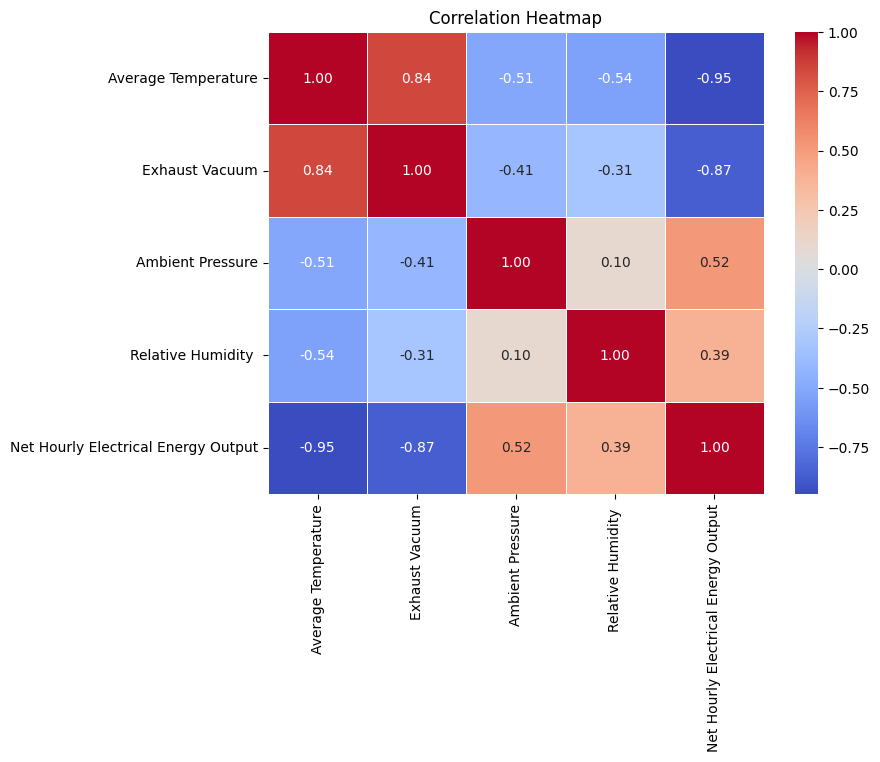

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the correlation with seaborn heatmap
plt.figure(figsize=(8, 6))
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Heatmap")
plt.show()

We draw the pairplot to visualize the relationship between the features and the target value.

We will utilize the `sns.pairplot()` method, with specific arguments tailored for regression tasks.

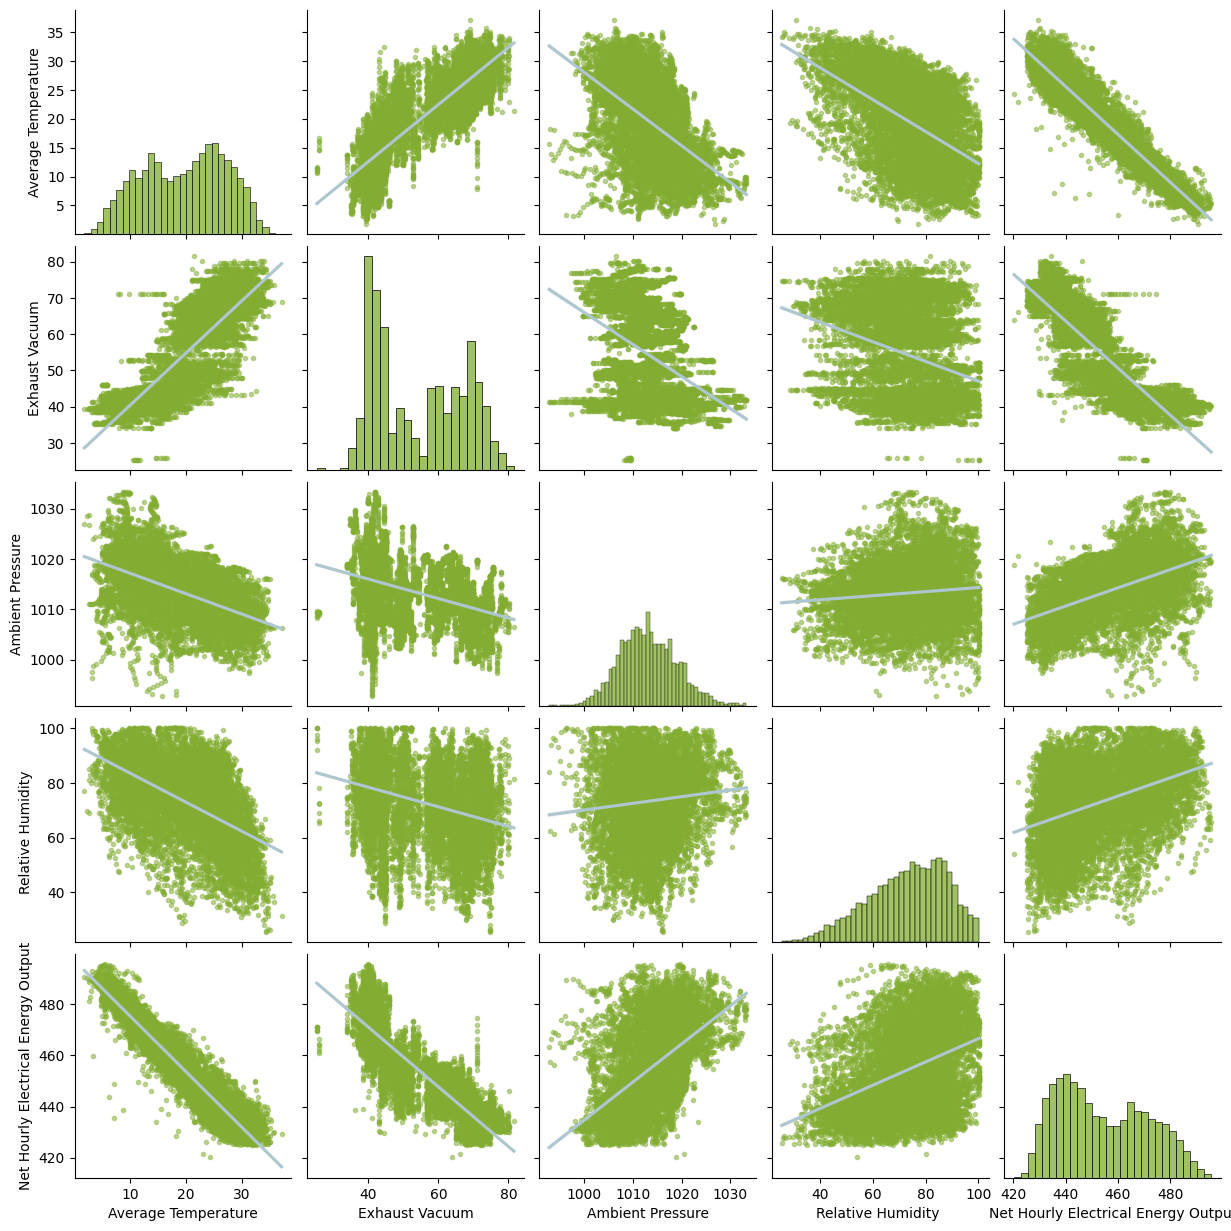

In [7]:
sns.pairplot(df,
                 markers=".",
                 kind='reg',
                 diag_kind="auto",
                 plot_kws={'line_kws':{'color':'#aec6cf'},
                           'scatter_kws': {'alpha': 0.5,
                                           'color': '#82ad32'}},

                 diag_kws= {'color': '#82ad32'})

## Input and Output selection

From the Correlation Heatmap and the PairPlot, we select `Average Temperature`, `Exhaust Vacuum`, `Ambient Pressure`, `Relative Humidity` as the input features.

The target of the regression task is the `Net Hourly Electrical Energy Output`.

# 3. Prepare data

## Prepare predictor and target data

In [8]:
predictors = df.drop("Net Hourly Electrical Energy Output", axis=1).values
targets = df["Net Hourly Electrical Energy Output"].values
print(predictors)
print(targets)

[[   8.34   40.77 1010.84   90.01]
 [  23.64   58.49 1011.4    74.2 ]
 [  29.74   56.9  1007.15   41.91]
 ...
 [  15.99   43.34 1014.2    78.66]
 [  17.65   59.87 1018.58   94.65]
 [  23.68   51.3  1011.86   71.24]]
[480.48 445.75 438.76 ... 465.96 450.93 451.67]


## Split data into training and test set

We use `train_test_split()` method from the `sklearn` library to split the predictors and targets data into a training and test set.


In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(predictors,targets, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(7654, 4)
(1914, 4)
(7654,)
(1914,)


## Standardizing input data

Standardization refers to the process of transforming features to have a mean of 0 and a standard deviation of 1.

This is also known as Z-score normalization.

This preprocessing step is crucial for input data before feeding the data to artificial neural networks.

The `StandardScaler` class in `sklearn.preprocessing` is used to perform standardization. Some important methods are:

1.   `StandardScaler()`: Creates an instance of the scaler.
2.   `fit(data)`: Calculates the mean and standard deviation for each feature in the provided `data`. These statistics are stored within the scaler object.
3.   `transform(data)`: Applies the calculated mean and standard deviation to the `data` to perform the standardization. For each value `x` in a feature, the transformation is `(x - mean) / standard_deviation`.
4.   `fit_transform(data)`: This is a convenience method that combines `fit()` and `transform()` in a single step.

Important Considerations:

*   **Outliers:** While `StandardScaler` is effective, it can be sensitive to outliers as they influence the calculation of the mean and standard deviation. For data with significant outliers, consider using robust scalers like `RobustScaler`.
*   **Training and Test Data:** It is crucial to fit the `StandardScaler` only on the training data and then use the same fitted scaler to transform both the training and test data to avoid data leakage.

In [10]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print(X_train)
print(X_test)

[[ 0.74805289  0.72006931 -0.32660017 -0.49711722]
 [ 0.86181948  1.26515721 -0.98521113  0.8181501 ]
 [ 0.93409473  1.52314975  0.32523844  0.80167494]
 ...
 [-0.22097078 -0.834965    0.36756563 -0.83554456]
 [ 0.94747903  1.14245344 -0.41971997 -0.45455637]
 [-1.77355014 -1.19049131  1.92520594  0.91837402]]
[[ 1.34499288  0.23869298 -1.28658067 -1.10532538]
 [ 0.81095912  1.36269098 -0.74140656  0.26485915]
 [-0.2437241  -0.73900436  1.99970178 -0.19713193]
 ...
 [-0.67068342 -1.15902881 -0.29951077 -0.10651852]
 [ 1.31420898  1.33752097 -0.87346737 -0.44288647]
 [-0.2611237  -0.27021304  0.37433797  1.10646548]]


# 4 - 6. Specify - Optimize - Fit model

## Specify neural network model

We will define a neural network with two hidden layers and one output layer, as shown in the following figure:

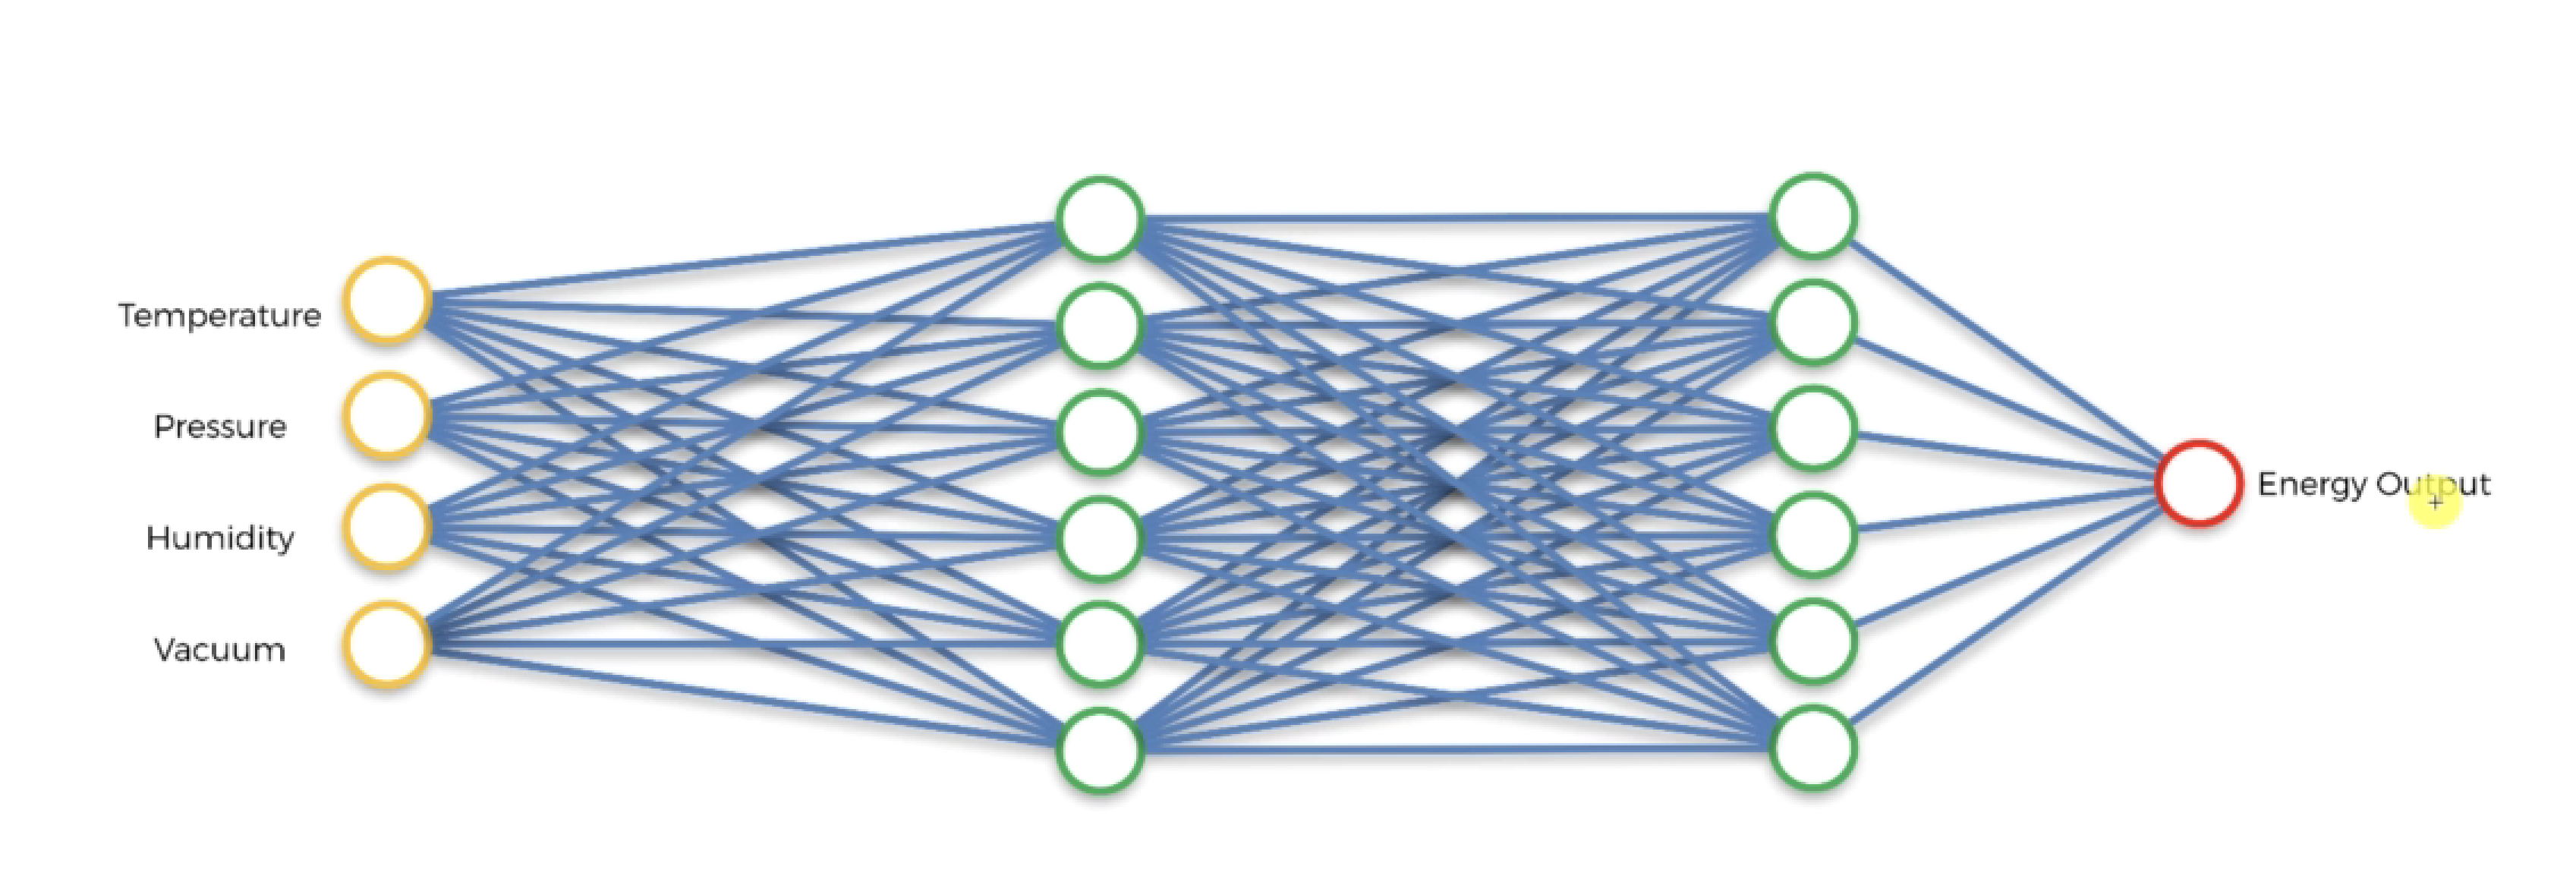

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping

def get_new_model():
  # Set up the model
  model = Sequential()
  model.add(Dense(6, activation='relu'))
  model.add(Dense(6, activation='relu'))

  # For a regression task, we do not need to add an activation function to the output layer
  model.add(Dense(1))

  return model

## Compile and fit the model

We will use adam optimizer algorithm. The `mean_squared_error` is used for loss metrics.

We also utilize `early_stopping_monitor`.

In [12]:
# Specify the model
model = get_new_model()

# Compile the model
model.compile(optimizer = 'adam', loss="mean_squared_error")

# Define early_stopping_monitor
early_stopping_monitor = EarlyStopping(monitor='val_loss', patience=4)

# Fit the model
history = model.fit(x=X_train, y=y_train, epochs=100, batch_size=32, validation_data=(X_test,y_test), callbacks=[early_stopping_monitor])

Epoch 1/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 205760.1719 - val_loss: 199665.4062
Epoch 2/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 194035.0781 - val_loss: 167105.5156
Epoch 3/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 153242.9219 - val_loss: 110641.4141
Epoch 4/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 97168.4219 - val_loss: 68574.4141
Epoch 5/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 61550.7461 - val_loss: 44895.2188
Epoch 6/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 39214.8008 - val_loss: 26383.9062
Epoch 7/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 22334.6504 - val_loss: 13857.7383
Epoch 8/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 11834.2705 - val_loss: 7686.8398
Epoch 9/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 6954.8735 - val_loss: 5067.8838
Epoch 10/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 4598.5728 - val_loss: 3608.9041
Epoch 11/100
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms

<Axes: >

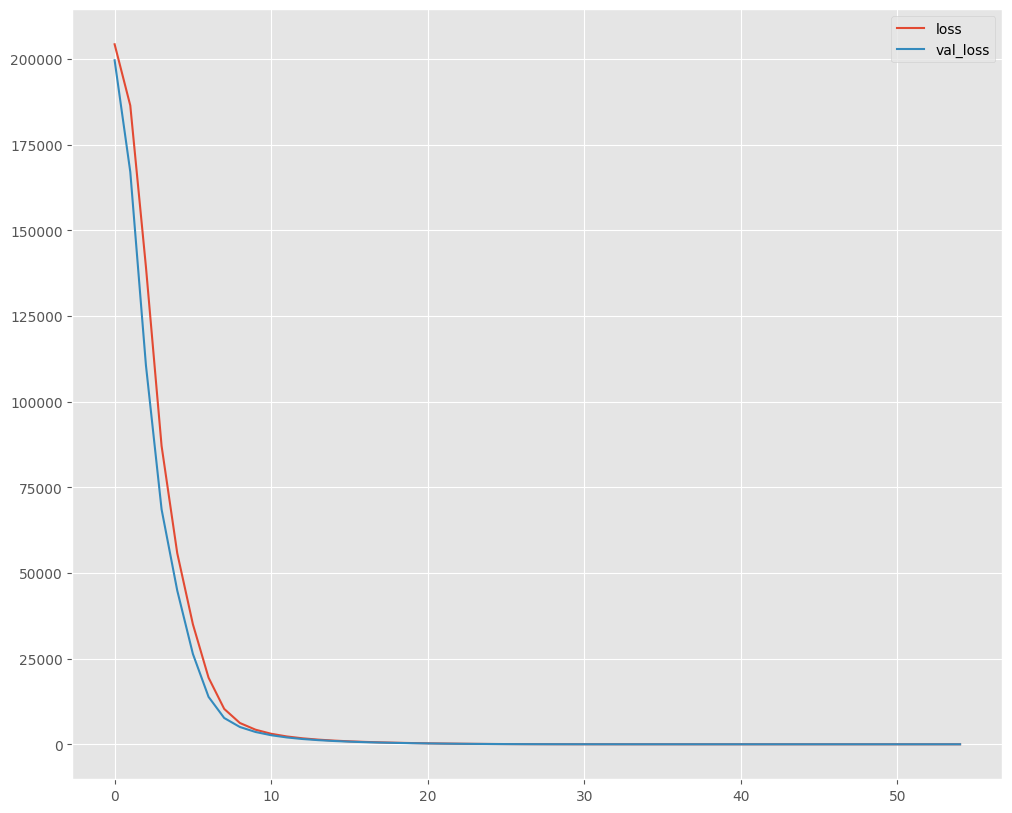

In [13]:
plt.style.use("ggplot")
pd.DataFrame(model.history.history).plot(figsize=(12,10))

# 7. Perform regression prediction

Now that we have a trained neural network, we can use it to predict new samples of penguin using the predict function.

We will use the neural network to predict the target values of test set using the `predict` function.

In [14]:
predictions = model.predict(X_test)

60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


We will visualize the real test values (`y_test`) versus the predicted values:

Text(0, 0.5, 'Actual Values')

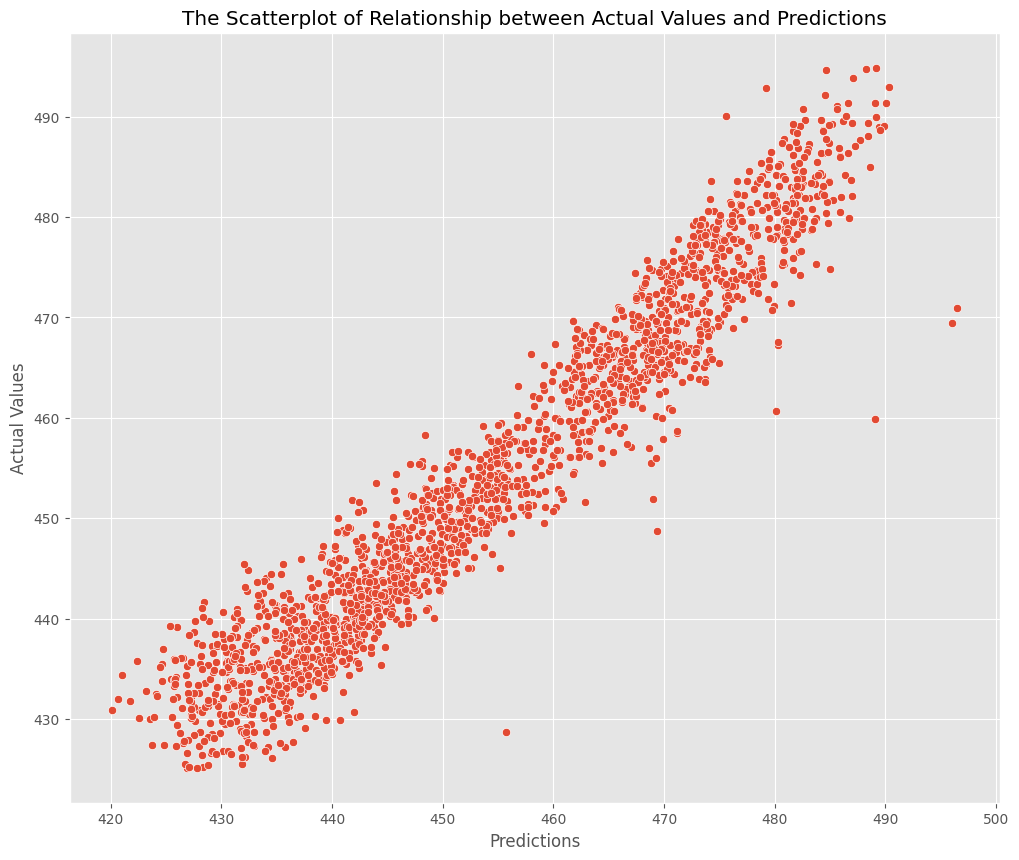

In [15]:
plt.figure(figsize=(12,10))
sns.scatterplot(x = np.ravel(predictions),y = y_test)
plt.title("The Scatterplot of Relationship between Actual Values and Predictions")
plt.xlabel("Predictions")
plt.ylabel("Actual Values")

It seems that our model predicts very well

# 8. Measure performance

In a regression task, we often evaluate our model performance by calculating the residual sum of squares and the explained variance score

In [16]:
from sklearn import metrics
print("MAE:", metrics.mean_absolute_error(y_test, predictions))
print ("MSE:", metrics.mean_squared_error(y_test, predictions))
print("RMSE:", np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 3.5697801222846053
MSE: 21.01453543001243
RMSE: 4.584161366052948


The Mean Absolute Error (MAE) is just 3.5 which is so small which shows that the model is almost as the actual values.

Now, we estimate the rate at which the target is predicted correctly:

In [17]:
metrics.explained_variance_score(y_test, predictions)

0.9266242553415083

This shows our model predict %93 of the target correctly